In [129]:
import numpy as np
from utils import plot_signals

# PLL
 1. Choose noise bandwidth $B_n$ for loop filter - between 1% and 5% of sample rate should be fine. The higher it is the more frequency offset PLL can handle, but it loses track more easily.
 2. Choose damping factor - typically between 0.5 and 2, $\frac{1}{\sqrt 2}$ (0.707) is commonly selected. The higher it is the less fluctuation there is while obtaining lock, but it takes longer.

$$K_p = \frac{1}{K_D K_0} \frac{4 \zeta}{\zeta + \frac{1}{4 \zeta}} \frac{B_n}{F_s}$$

$$K_i = \frac{1}{K_D K_0} \frac{4}{(\zeta + \frac{1}{4 \zeta})^2} (\frac{B_n}{F_s})^2$$

$K_D$ is phase error detector gain and $K_0$ is NCO gain (typically set to 1).

Source: [WirelessPi on PLLs](https://wirelesspi.com/phase-locked-loop-pll-in-a-software-defined-radio-sdr/)

In [2]:
def calc_loop_params(damping_factor, noise_bandwidth, sample_rate, ped_gain=0.5, nco_gain=1):
    k_p = (4 * damping_factor * noise_bandwidth) / (ped_gain * nco_gain * (damping_factor + 1 / (4 * damping_factor)) * sample_rate)
    k_i = (4 * noise_bandwidth ** 2) / (ped_gain * nco_gain * ((damping_factor + 1 / (4 * damping_factor)) * sample_rate) ** 2)
    return k_p, k_i

In [98]:
f_0 = 19000
sample_rate = 250_000
k_p, k_i = calc_loop_params(1 / np.sqrt(2), 0.05 * sample_rate, sample_rate)
k_p, k_i  # just like on WirelessPi

(0.26666666666666666, 0.01777777777777778)

In [84]:
def pll(input_signal, sample_rate, f_0, k_p, k_i, nco_gain):
    phases, errors = [], []
    integrator_acc, phase = 0, 0
    
    for i, sample in enumerate(input_signal):
        # cos here means phases will be for use in sin function
        error = np.cos(2 * np.pi * f_0 * i / sample_rate + phase) * sample
        
        integrator_acc += (k_i * error)
        phase += (nco_gain * (integrator_acc + k_p * error))

        phases.append(phase)
        errors.append(error)
        
    return phases, errors

### PLL on signal with phase offset

In [161]:
t_s = np.arange(0, 1, 1 / sample_rate)
phase_offset = 0.8 * np.pi
signal = np.sin(2 * np.pi * f_0 * t_s + phase_offset)
phases, errors = pll(signal, sample_rate, f_0, k_p, k_i, 1)

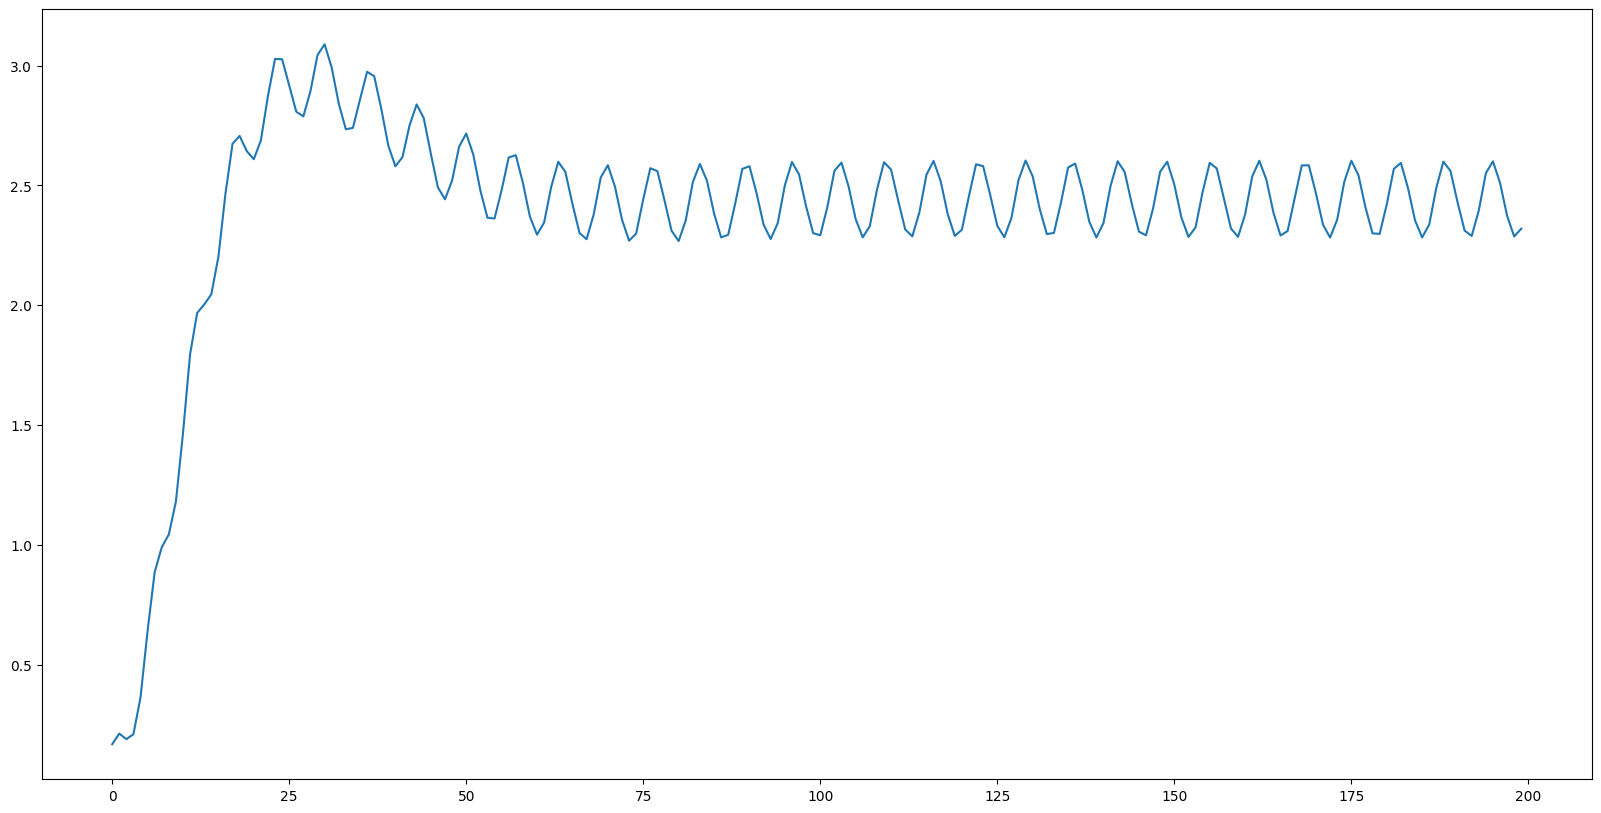

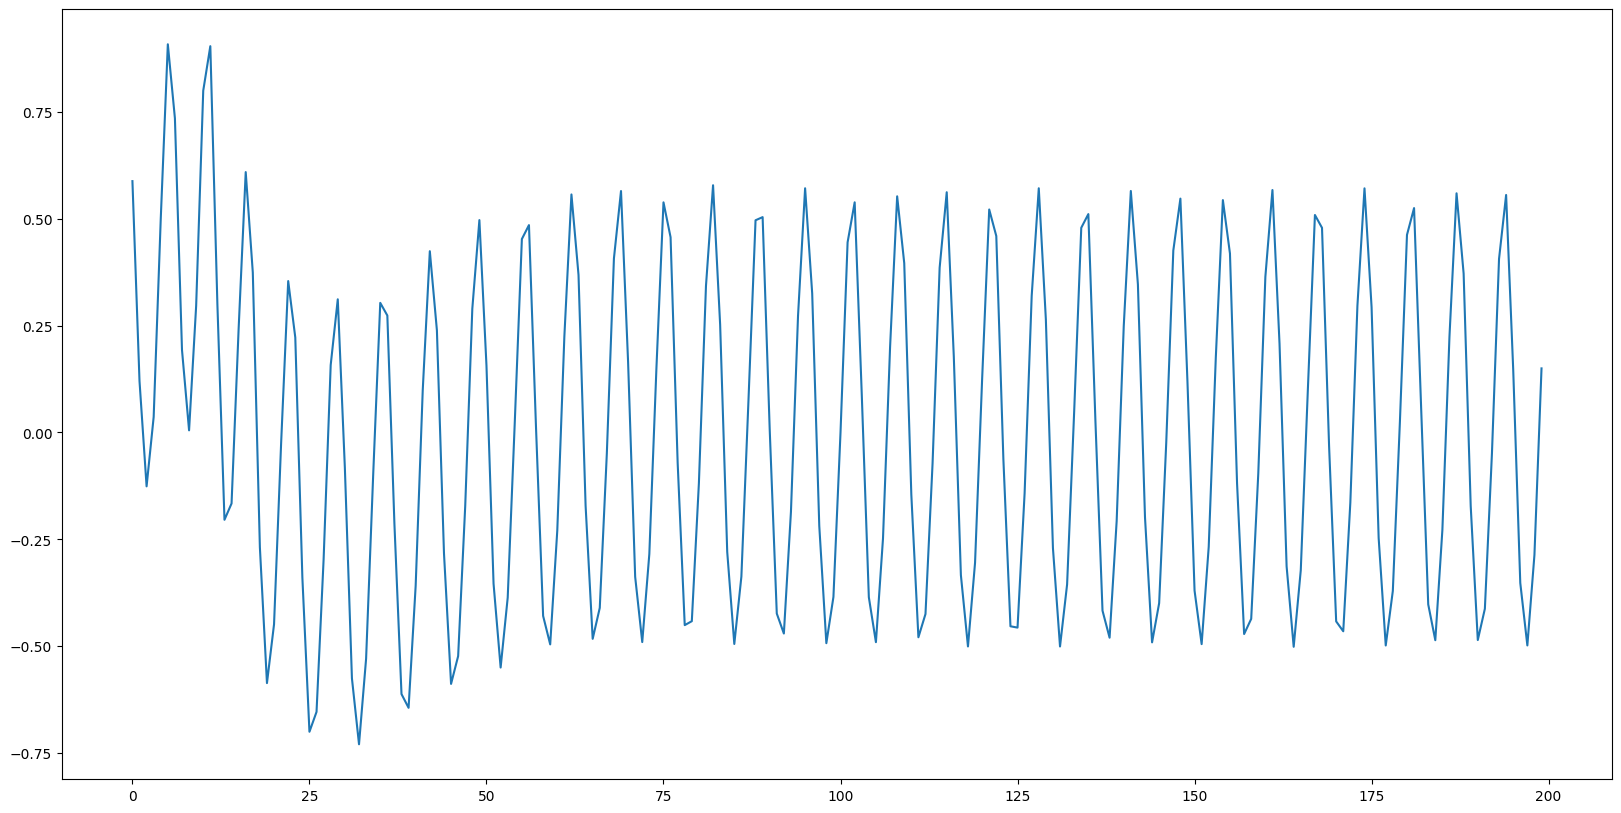

In [162]:
start, width = 0, 200
plot_signals([phases], start=start, width=width, normalize=False)
plot_signals([errors], start=start, width=width, normalize=False)

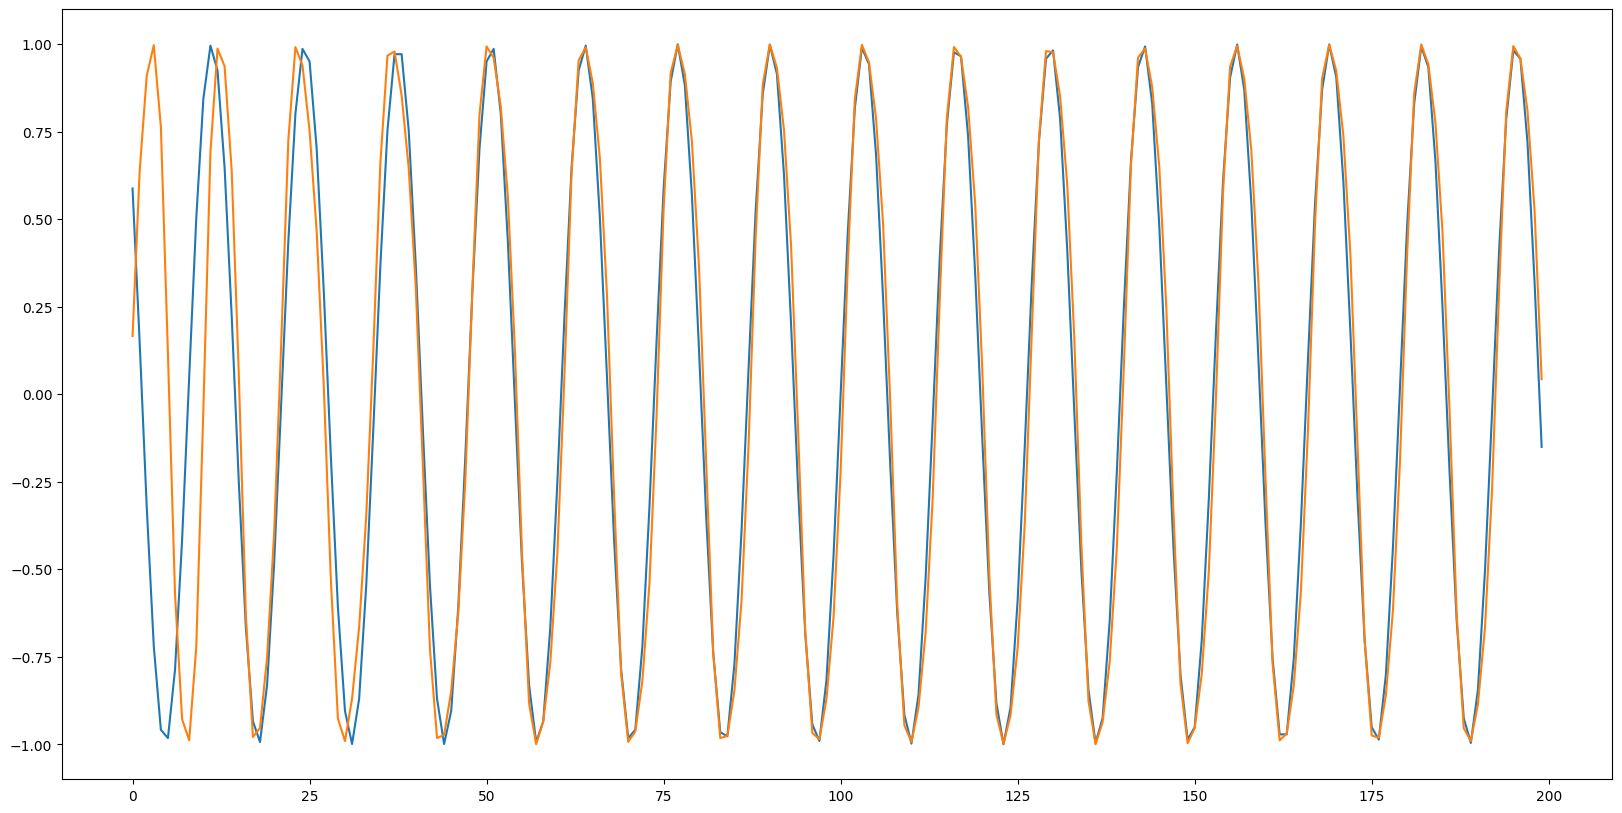

In [111]:
plot_signals([signal, np.sin(2 * np.pi * f_0 * t_s + phases)], start=start, width=width)

### PLL with frequency and phase offset
Interesting, with these parameters it can handle really high frequency offset (10kHz vs $f_0$ of 19kHz).

In [126]:
frequency_offset = 10000
signal = np.sin(2 * np.pi * (f_0 + frequency_offset) * t_s + phase_offset)
phases, errors = pll(signal, sample_rate, f_0, k_p, k_i, 1)

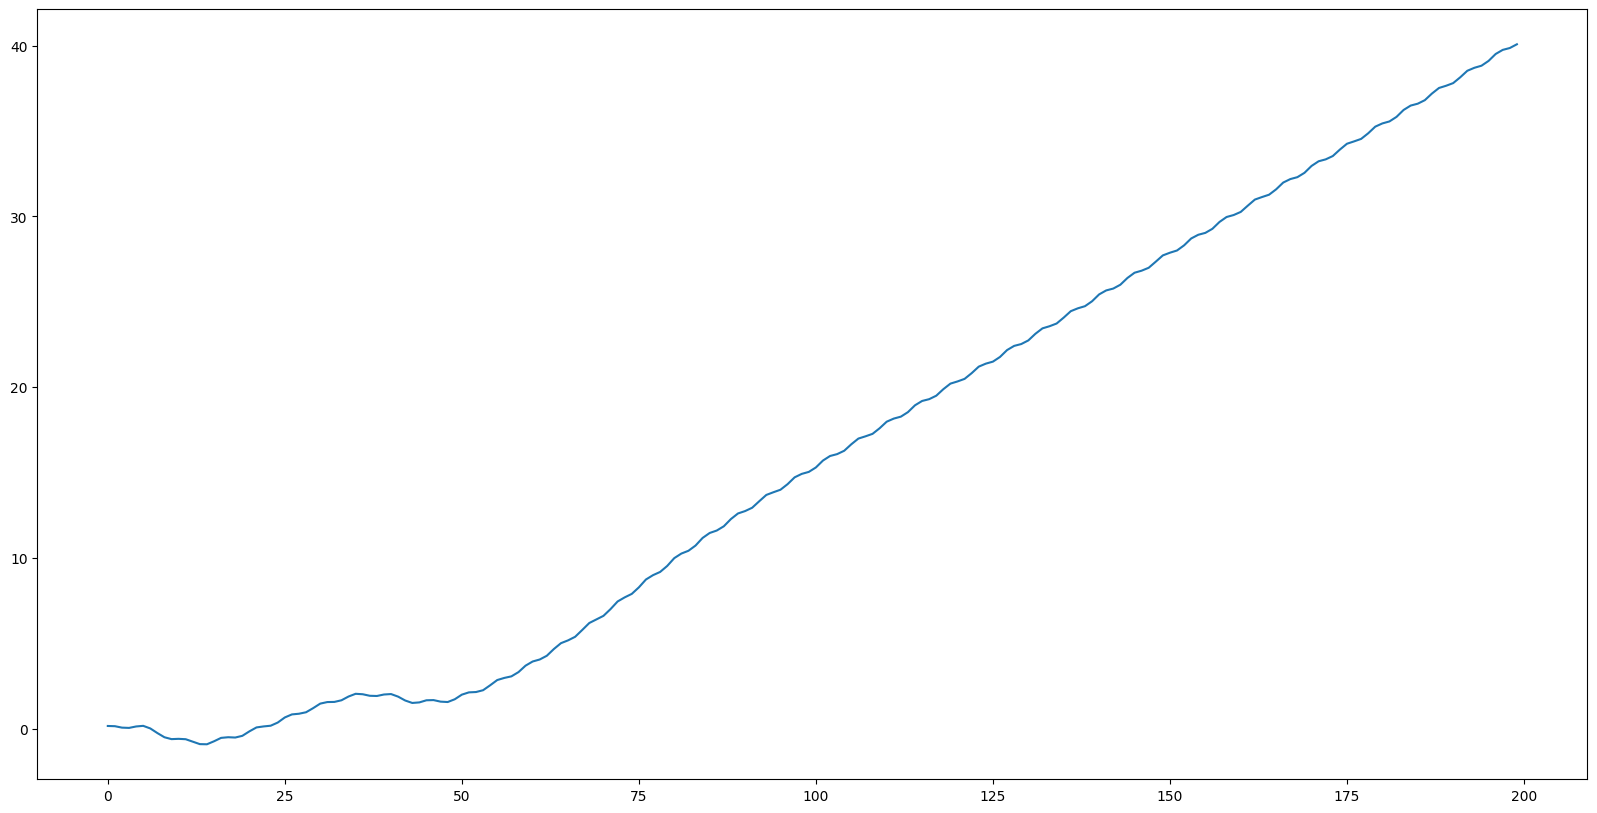

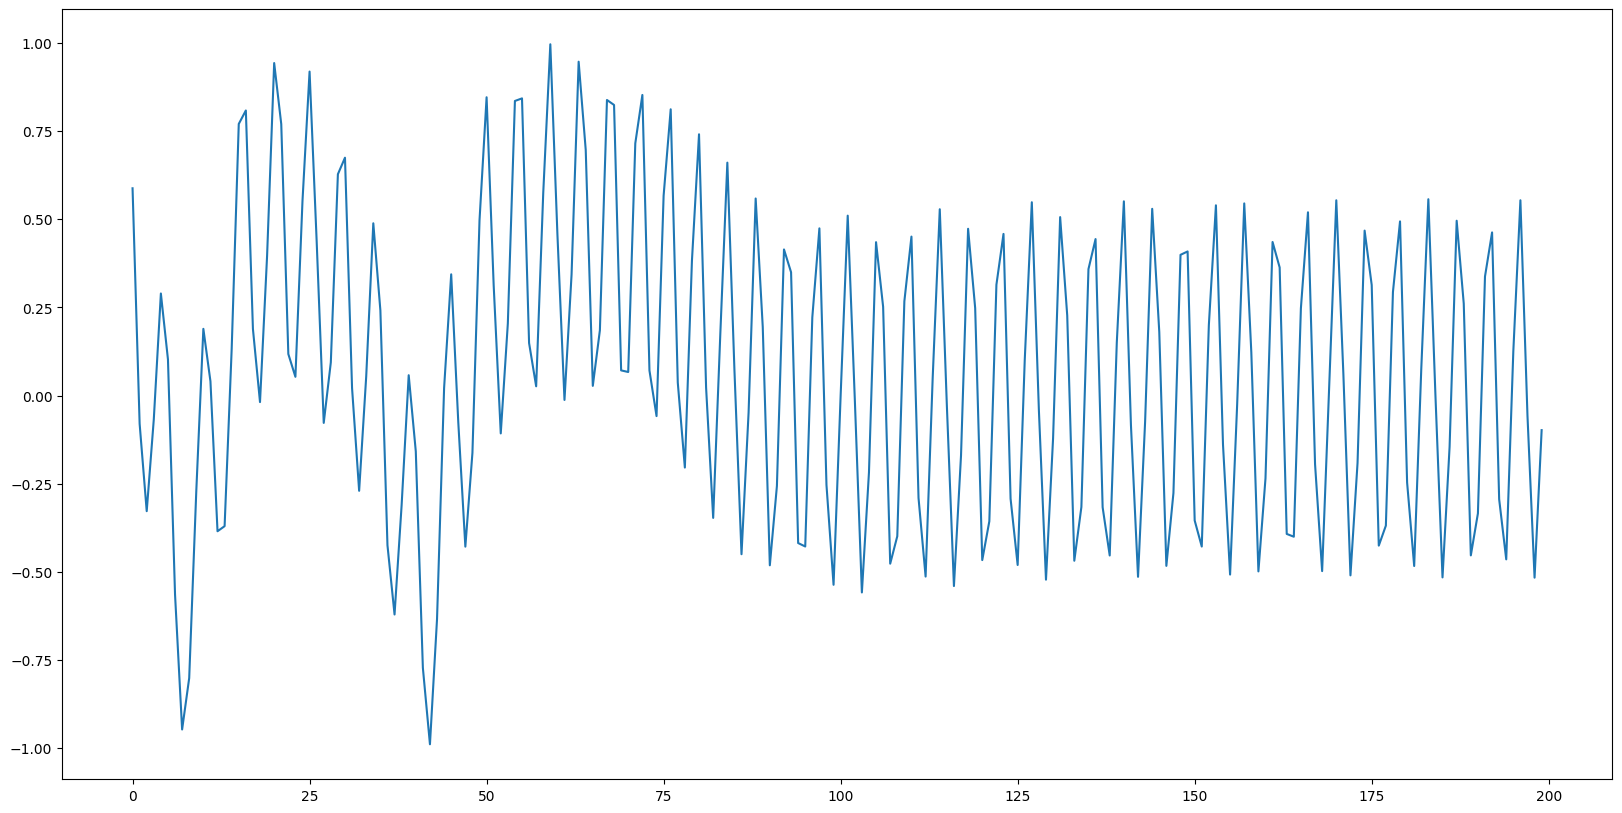

In [127]:
plot_signals([phases], start=start, width=width, normalize=False)
plot_signals([errors], start=start, width=width, normalize=False)

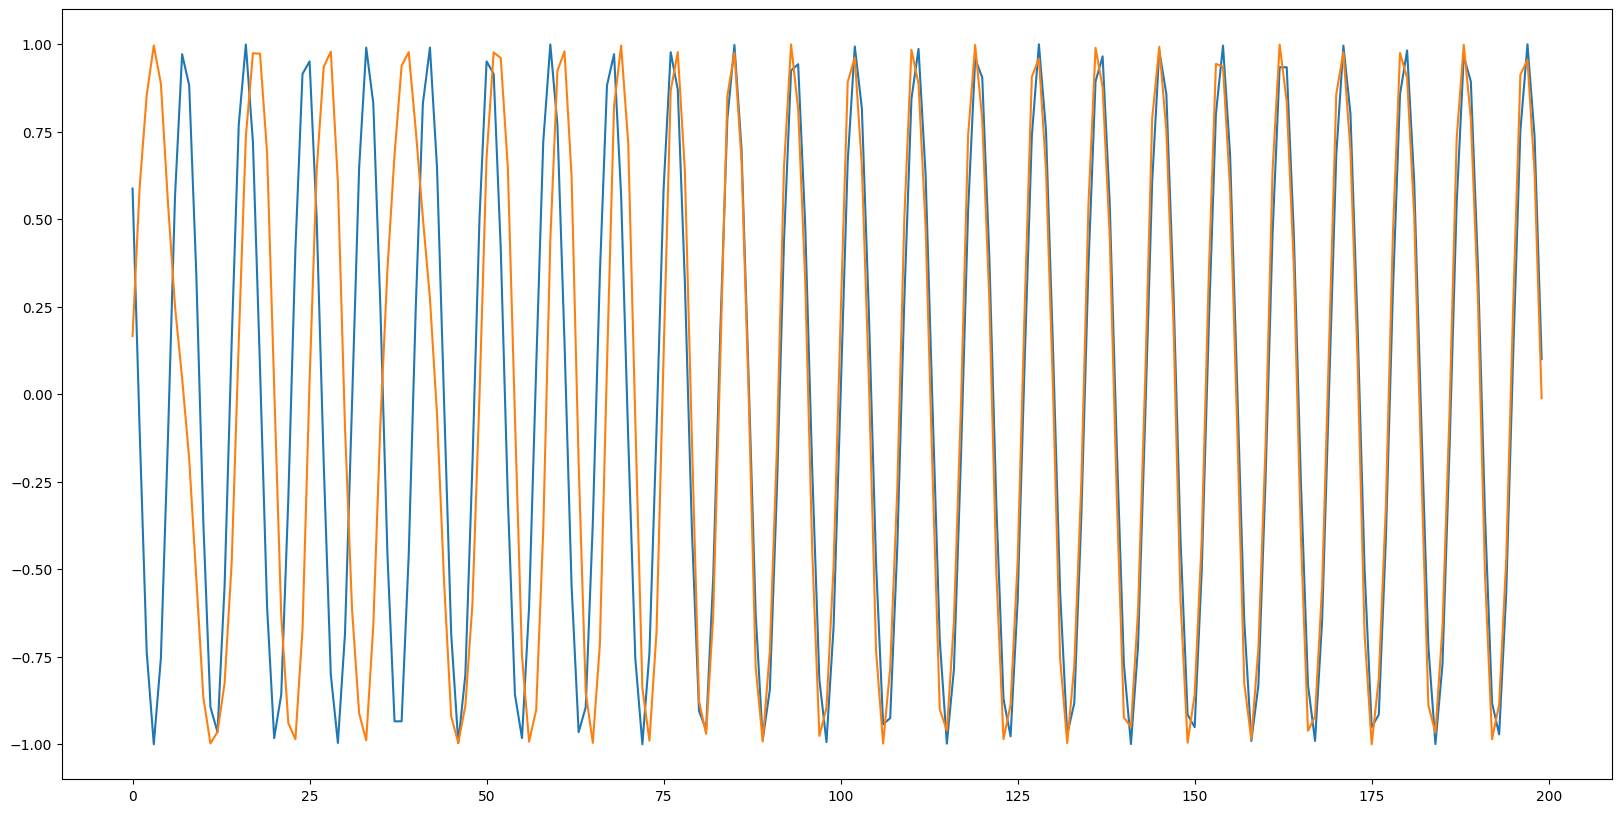

In [128]:
plot_signals([signal, np.sin(2 * np.pi * f_0 * t_s + phases)], start=start, width=width)

# Costas loop
AFAIU PLL above won't work for e.g. BPSK modulated signal. We need additional trickery to get phase error between our estimate and carrier phase.

Cool realization: we do need time synchronization before Costas loop in RDS processing. Costas loop assumes that $m^2(t) = 1$ so that's after we saw pulse shaped signal and picked the maximum points using e.g. M&M algorithm.

Sources:
 - [Costas loop in GNURadio](https://github.com/gnuradio/gnuradio/blob/main/gr-digital/lib/clock_tracking_loop.h#L363)
 - [loop filter for Costas loop from GNURadio](https://github.com/gnuradio/gnuradio/blob/main/gr-digital/lib/clock_tracking_loop.h#L363)

In [195]:
def costas_loop(input_signal, sample_rate, f_0):
    # todo: this can act as a demodulator with a LPF
    alpha = 0.8
    beta = 0.002
    
    phases, errors, msg = [], [], []
    integrator_acc, phase = 0, 0
    
    for i, sample in enumerate(input_signal):
        sin_res = np.sin(2 * np.pi * f_0 * i / sample_rate + phase) * sample
        cos_res = np.cos(2 * np.pi * f_0 * i / sample_rate + phase) * sample
        error = sin_res * cos_res

        integrator_acc += beta * error
        phase += integrator_acc + alpha * error

        phases.append(phase)
        errors.append(error)
        msg.append(sin_res)

    return phases, errors, msg

In [200]:
t_s = np.arange(0, 1, 1 / sample_rate)
f_rds = 57000
phase_offset = 0.8 * np.pi
carrier = np.sin(2 * np.pi * f_rds * t_s + phase_offset)

# 1187.5 symbols per second in RDS
samples_per_symbol = sample_rate // 1187.5
# bpsk_data = 2 * np.random.randint(0, 2, size=[int(len(t_s) / samples_per_symbol)]) - 1  # random -1 and 1
# bpsk_data = np.repeat(bpsk_data, samples_per_symbol)
bpsk_data = np.ones(len(t_s))
if len(bpsk_data) < len(t_s):
    bpsk_data = np.pad(bpsk_data, (0, len(t_s) - len(bpsk_data)), 'constant')

bpsk_mod_signal = bpsk_data * carrier

In [201]:
phases, errors, msg = costas_loop(bpsk_mod_signal, sample_rate, f_rds)

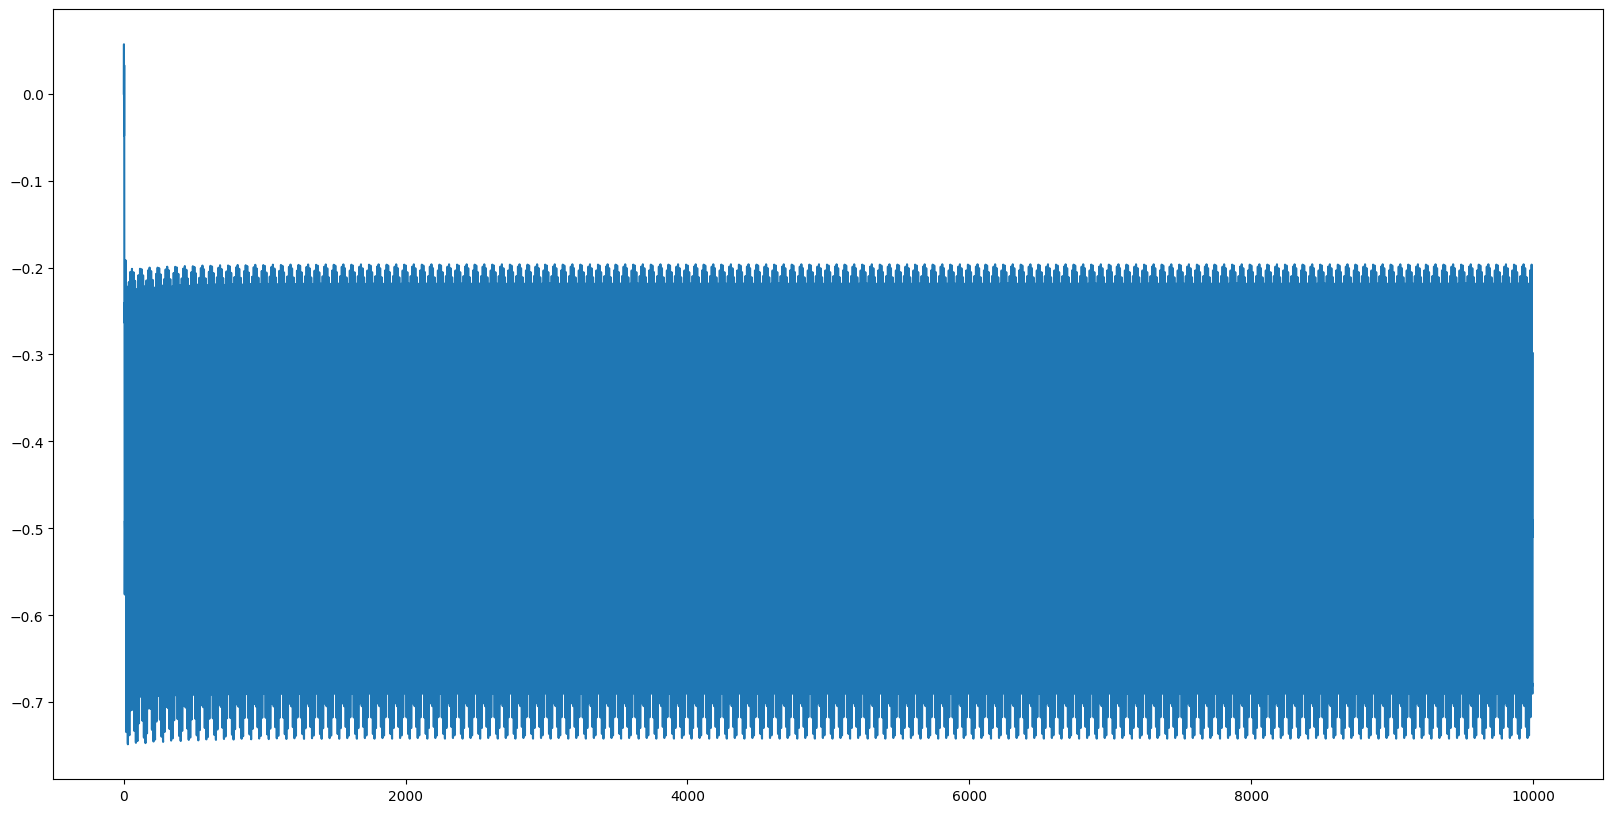

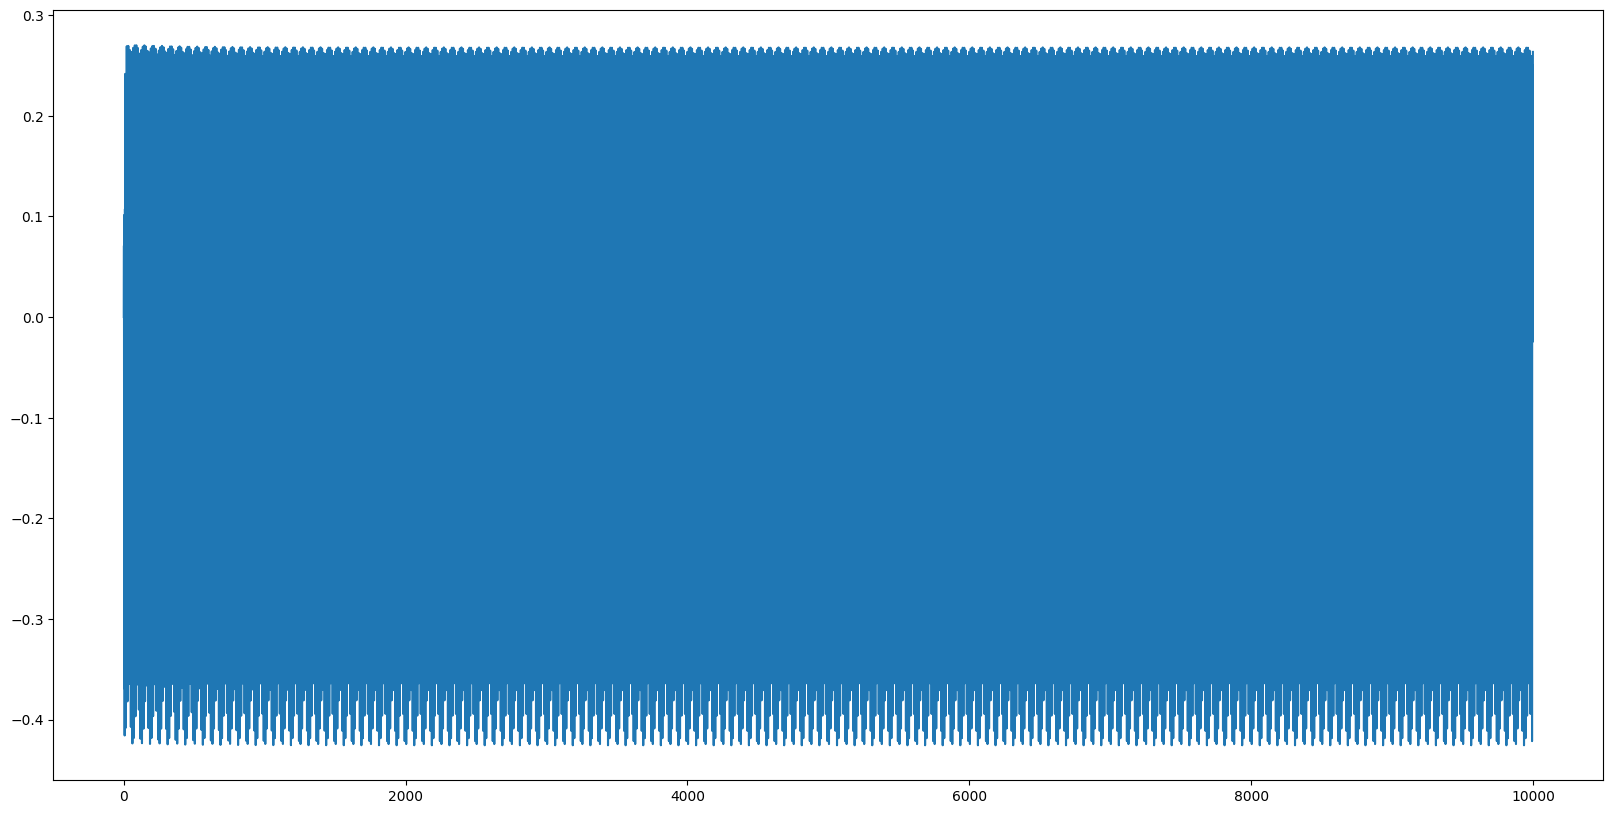

In [202]:
start, width = 0, 10000
plot_signals([phases], start=start, width=width, normalize=False)
plot_signals([errors], start=start, width=width, normalize=False)

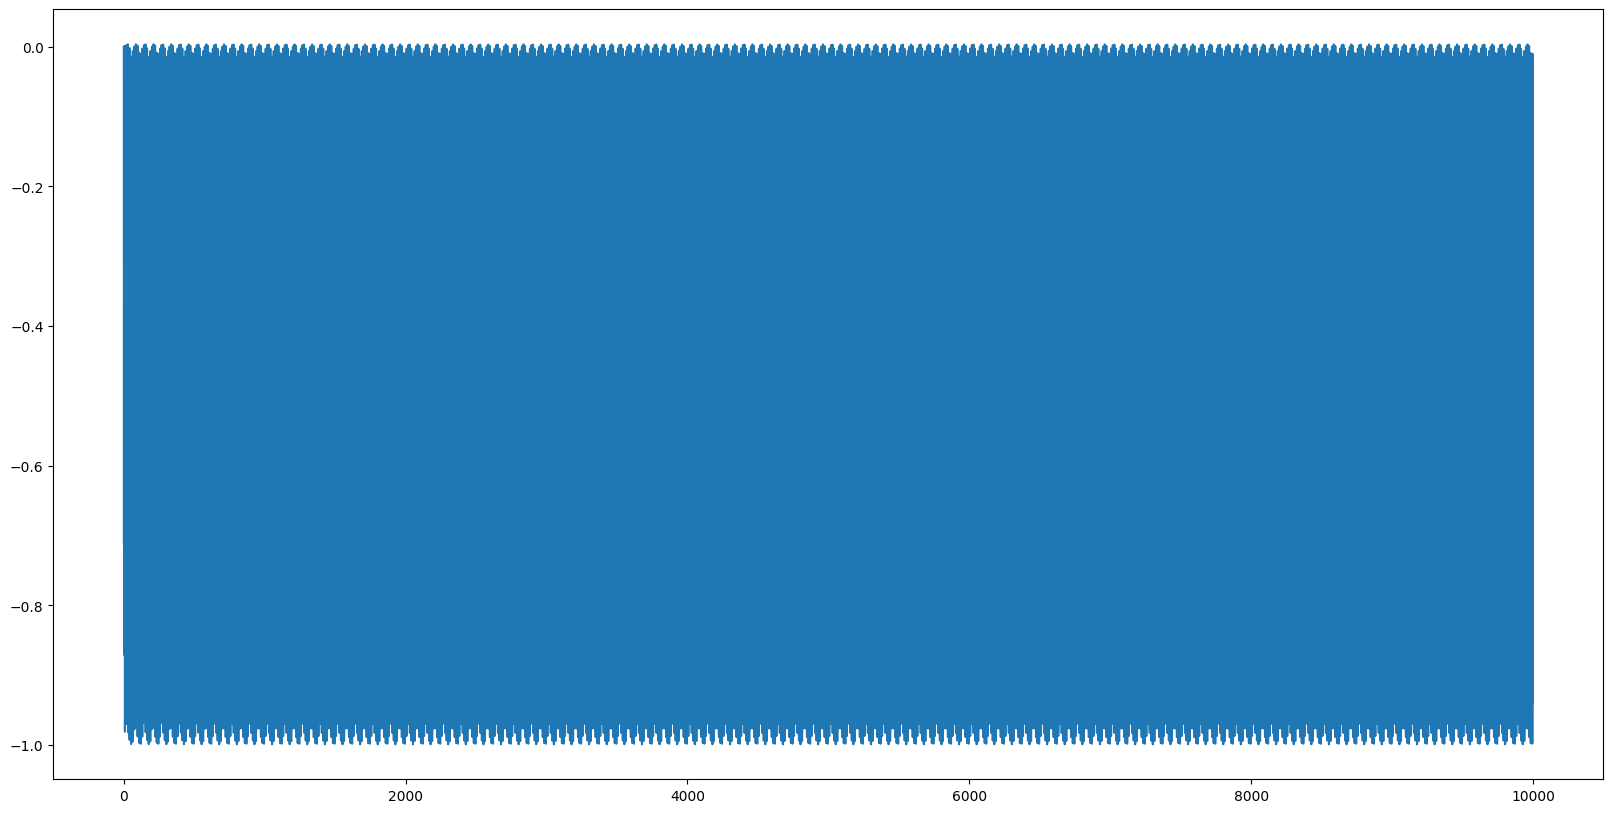

In [203]:
plot_signals([msg], start=start, width=width, normalize=False)

# Costas loop with frequency and phase offset